# EDA & Préprocessing

## Importation des données

In [361]:
# import libraries
import warnings
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', 200)


In [362]:
# import datas
PATH_FILE = 'input'
application_train = pd.read_csv(f'{PATH_FILE}/application_train.csv')
bureau = pd.read_csv(f'{PATH_FILE}/bureau.csv')
bureau_balance = pd.read_csv(f'{PATH_FILE}/bureau_balance.csv')
pos_cash = pd.read_csv(f'{PATH_FILE}/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv(f'{PATH_FILE}/credit_card_balance.csv')
previous_application = pd.read_csv(f'{PATH_FILE}/previous_application.csv')
installments_payments = pd.read_csv(f'{PATH_FILE}/installments_payments.csv')
columns_description = pd.read_csv(f'{PATH_FILE}/HomeCredit_columns_description.csv', sep=';', encoding='latin1')


### Description des données

In [58]:
datasets = [application_train, bureau, bureau_balance, pos_cash, credit_card_balance, 
            previous_application, installments_payments, columns_description]

df_names = ["application_train", "bureau", "bureau_balance", "pos_cash", "credit_card_balance", 
          "previous_application", "installments_payments", "columns_description"]

info_df = pd.DataFrame({},)
info_df['dataset'] = df_names
info_df['nb_columns'] = [len(df.columns) for df in datasets]
info_df['columns_name'] = [', '.join(list(df.columns)) for df in datasets]
info_df['nb_rows'] = [len(df) for df in datasets]
info_df
info_df.style.background_gradient(cmap='PuBu')

,dataset,nb_columns,columns_name,nb_rows
0,application_train,122,"SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR",307511
1,bureau,17,"SK_ID_CURR, SK_ID_BUREAU, CREDIT_ACTIVE, CREDIT_CURRENCY, DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, AMT_CREDIT_MAX_OVERDUE, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, CREDIT_TYPE, DAYS_CREDIT_UPDATE, AMT_ANNUITY",1716428
2,bureau_balance,3,"SK_ID_BUREAU, MONTHS_BALANCE, STATUS",27299925
3,pos_cash,8,"SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, CNT_INSTALMENT, CNT_INSTALMENT_FUTURE, NAME_CONTRACT_STATUS, SK_DPD, SK_DPD_DEF",10001358
4,credit_card_balance,23,"SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, AMT_BALANCE, AMT_CREDIT_LIMIT_ACTUAL, AMT_DRAWINGS_ATM_CURRENT, AMT_DRAWINGS_CURRENT, AMT_DRAWINGS_OTHER_CURRENT, AMT_DRAWINGS_POS_CURRENT, AMT_INST_MIN_REGULARITY, AMT_PAYMENT_CURRENT, AMT_PAYMENT_TOTAL_CURRENT, AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE, CNT_DRAWINGS_ATM_CURRENT, CNT_DRAWINGS_CURRENT, CNT_DRAWINGS_OTHER_CURRENT, CNT_DRAWINGS_POS_CURRENT, CNT_INSTALMENT_MATURE_CUM, NAME_CONTRACT_STATUS, SK_DPD, SK_DPD_DEF",3840312
5,previous_application,37,"SK_ID_PREV, SK_ID_CURR, NAME_CONTRACT_TYPE, AMT_ANNUITY, AMT_APPLICATION, AMT_CREDIT, AMT_DOWN_PAYMENT, AMT_GOODS_PRICE, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, FLAG_LAST_APPL_PER_CONTRACT, NFLAG_LAST_APPL_IN_DAY, RATE_DOWN_PAYMENT, RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED, NAME_CASH_LOAN_PURPOSE, NAME_CONTRACT_STATUS, DAYS_DECISION, NAME_PAYMENT_TYPE, CODE_REJECT_REASON, NAME_TYPE_SUITE, NAME_CLIENT_TYPE, NAME_GOODS_CATEGORY, NAME_PORTFOLIO, NAME_PRODUCT_TYPE, CHANNEL_TYPE, SELLERPLACE_AREA, NA

### Répartition variables numériques et qualitatives

In [59]:
df_columns_type = pd.DataFrame({},)
df_columns_type['dataset'] = df_names
df_columns_type['numeric_columns'] = [len((df.select_dtypes(include=np.number)).columns) for df in datasets]
df_columns_type['numeric_columns_name'] = [', '.join(list((df.select_dtypes(include=np.number)).columns)) for df in datasets]
df_columns_type['object_columns'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
df_columns_type['object_columns_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
df_columns_type.style.background_gradient(cmap='PuBu')

,dataset,numeric_columns,numeric_columns_name,object_columns,object_columns_name
0,application_train,106,"SK_ID_CURR, TARGET, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, TOTALAREA_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR",16,"NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, OCCUPATION_TYPE, WEEKDAY_APPR_PROCESS_START, ORGANIZATION_TYPE, FONDKAPREMONT_MODE, HOUSETYPE_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE"
1,bureau,14,"SK_ID_CURR, SK_ID_BUREAU, DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, AMT_CREDIT_MAX_OVERDUE, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, DAYS_CREDIT_UPDATE, AMT_ANNUITY",3,"CREDIT_ACTIVE, CREDIT_CURRENCY, CREDIT_TYPE"
2,bureau_balance,2,"SK_ID_BUREAU, MONTHS_BALANCE",1,STATUS
3,pos_cash,7,"SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, CNT_INSTALMENT, CNT_INSTALMENT_FUTURE, SK_DPD, SK_DPD_DEF",1,NAME_CONTRACT_STATUS
4,credit_card_balance,22,"SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, AMT_BALANCE, AMT_CREDIT_LIMIT_ACTUAL, AMT_DRAWINGS_ATM_CURRENT, AMT_DRAWINGS_CURRENT, AMT_DRAWINGS_OTHER_CURRENT, AMT_DRAWINGS_POS_CURRENT, AMT_INST_MIN_REGULARITY, AMT_PAYMENT_CURRENT, AMT_PAYMENT_TOTAL_CURRENT, AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE, CNT_DRAWINGS_ATM_CURRENT, CNT_DRAWINGS_CURRENT, CNT_DRAWINGS_OTHER_CURRENT, CNT_DRAWINGS_POS_CURRENT, CNT_INSTALMENT_MATURE_CUM, SK_DPD, SK_DPD_DEF",1,NAME_CONTRACT_STATUS
5,previous_application,21,"SK_ID_PREV, SK_ID_CURR, AMT_ANNUITY, AMT_APPLICATION, AMT_CREDIT, AMT_DOWN_PAYMENT, AMT_GOODS_PRICE, HOUR_APPR_PROCESS_START, NFLAG_LAST_APPL_IN_DAY, RATE_DOWN_PAYMENT, RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED, DAYS_DECISION, SELLERPLACE_AREA, CNT_PAYMENT, DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION, NFLAG_INSURED_ON_APPROVAL",16,"NAME_CONTRACT_TYPE, WEEKDAY_APPR_PROCESS_START, FLAG_LAST_APPL_PER_CONTRACT, NAME_CASH_LOAN_PURPOSE, NAME_CONTRACT_STATU

### Variable Cible : Distribution
Déséquilibre de la répartition des valeurs, les clients en défaut de paiement sont **sous-représentés**.

(307511, 122)


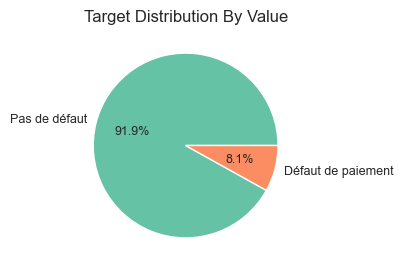

In [363]:

# Répartition de la variable cible
print(application_train.shape)

plt.figure(figsize=(3,3))
labels=["Pas de défaut","Défaut de paiement"]
plt.pie(application_train["TARGET"].value_counts(),
        labels = labels,
        autopct='%.01f%%',
        textprops={'fontsize':9},
        colors=sns.color_palette('Set2')
)
plt.title(label="Target Distribution By Value")
plt.show()

# Fonctions

#### One Hot Encoder

In [364]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    df.columns = df.columns.str.replace(' ', '_')
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

#### Drop Columns with missing values

In [365]:
# Function to calculate missing values by column# Funct 
def drop_cols_with_missing_values(df, seuil):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    cols_with_missing_values = [col for col in df.columns if df[col].isnull().mean() > seuil]

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.\n"
        "There are " + str(len(cols_with_missing_values)) + f" columns that have more than {seuil*100}% of missing values.\n")


    df = df.drop(labels=cols_with_missing_values, axis=1, inplace=False)

    # Return the dataframe with missing information
    return df, cols_with_missing_values


#### Print Categorical columns info

In [366]:
# Liste des valeurs uniques dans les colonnes catégorielles restantes
def print_categorical_cols_info(df):
    categorical_columns = df.select_dtypes(include='object').columns
    df_distinct_values_cat_columns = pd.DataFrame({},)
    df_distinct_values_cat_columns['categorical_columns'] = categorical_columns
    df_distinct_values_cat_columns['nb_distinct_values'] = [df[col].nunique() for col in df[categorical_columns]]
    df_distinct_values_cat_columns['list_of_values'] = [', '.join(np.unique(df[col].values)) for col in categorical_columns]
    styled_df = df_distinct_values_cat_columns.style.background_gradient(cmap='PuBu')

    return categorical_columns, styled_df

#### Check Spearman Correlation

In [367]:
# Corrélation Spearman
def check_spearman_correlation(df, seuil):
    # plt.figure(figsize = (20, 10))
    # Compute the correlation matrix
    df_num = df.select_dtypes(include=[np.number])
    corr_matrix = df_num.corr(numeric_only=True, method = 'spearman')

    # Plot the heatmap of the correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 20 / np.sqrt(len(corr_matrix))})
    plt.show()

    # Identify highly correlated pairs
    corr_pairs = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
    high_corr = [(a, b) for a, b in corr_pairs.index if a != b and corr_pairs[(a, b)] > seuil]
    
    return high_corr

In [368]:
# Categorical Variables
def categorial_col_desc(dataframe, variable):
    print(variable)
    print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe) *100}), end="\n\n\n")

# Application Train

## Valeurs manquantes

In [369]:
df_app_train = application_train.copy()

In [370]:
# NaN values for DAYS_EMPLOYED: 365243 -> nan
df_app_train.loc[df_app_train['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan


In [371]:
# Missing values statistics
# missing_values, cols_with_50pct_missing_values = drop_cols_with_missing_values(application_train, seuil = 0.5)
df_app_train, cols_with_50pct_missing_values = drop_cols_with_missing_values(df_app_train, seuil = 0.5)


Your selected dataframe has 122 columns.
There are 68 columns that have missing values.
There are 41 columns that have more than 50.0% of missing values.



In [373]:
print(df_app_train.shape)

(307511, 81)


### Imputation des valeurs manquantes

In [374]:
# Suppression de la variable cible dans le X-train
y_train = df_app_train['TARGET']
X_train = df_app_train.drop(labels='TARGET', axis=1, inplace=False)
X_train.shape, y_train.shape

# Split numerical and categorical columns
numeric_columns = X_train.select_dtypes(include='number').columns
categorical_columns = X_train.select_dtypes(include='object').columns

#create two DataFrames, one for each data type
data_numeric = X_train[numeric_columns]
data_categorical = X_train[categorical_columns]

# Impute missing values for numerical columns with median values
si = SimpleImputer(missing_values=np.nan, strategy='median')
data_numeric = pd.DataFrame(si.fit_transform(data_numeric), columns = si.get_feature_names_out())

# Impute missing values for categorical columns with most frequent values
si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_categorical = pd.DataFrame(si.fit_transform(data_categorical), columns = si.get_feature_names_out())

In [375]:
# Check null values for data_numeric
data_numeric[numeric_columns].isnull().mean()

SK_ID_CURR                      0.0
CNT_CHILDREN                    0.0
AMT_INCOME_TOTAL                0.0
AMT_CREDIT                      0.0
AMT_ANNUITY                     0.0
AMT_GOODS_PRICE                 0.0
REGION_POPULATION_RELATIVE      0.0
DAYS_BIRTH                      0.0
DAYS_EMPLOYED                   0.0
DAYS_REGISTRATION               0.0
DAYS_ID_PUBLISH                 0.0
FLAG_MOBIL                      0.0
FLAG_EMP_PHONE                  0.0
FLAG_WORK_PHONE                 0.0
FLAG_CONT_MOBILE                0.0
FLAG_PHONE                      0.0
FLAG_EMAIL                      0.0
CNT_FAM_MEMBERS                 0.0
REGION_RATING_CLIENT            0.0
REGION_RATING_CLIENT_W_CITY     0.0
HOUR_APPR_PROCESS_START         0.0
REG_REGION_NOT_LIVE_REGION      0.0
REG_REGION_NOT_WORK_REGION      0.0
LIVE_REGION_NOT_WORK_REGION     0.0
REG_CITY_NOT_LIVE_CITY          0.0
REG_CITY_NOT_WORK_CITY          0.0
LIVE_CITY_NOT_WORK_CITY         0.0
EXT_SOURCE_2                

In [376]:
# Check null values for data_categorical
data_categorical[categorical_columns].isnull().mean()

NAME_CONTRACT_TYPE            0.0
CODE_GENDER                   0.0
FLAG_OWN_CAR                  0.0
FLAG_OWN_REALTY               0.0
NAME_TYPE_SUITE               0.0
NAME_INCOME_TYPE              0.0
NAME_EDUCATION_TYPE           0.0
NAME_FAMILY_STATUS            0.0
NAME_HOUSING_TYPE             0.0
OCCUPATION_TYPE               0.0
WEEKDAY_APPR_PROCESS_START    0.0
ORGANIZATION_TYPE             0.0
EMERGENCYSTATE_MODE           0.0
dtype: float64

In [377]:
#join the two masked dataframes back together
df_app_train = pd.concat([data_numeric, data_categorical], axis = 1)

In [378]:
df_app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 80 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  float64
 1   CNT_CHILDREN                  307511 non-null  float64
 2   AMT_INCOME_TOTAL              307511 non-null  float64
 3   AMT_CREDIT                    307511 non-null  float64
 4   AMT_ANNUITY                   307511 non-null  float64
 5   AMT_GOODS_PRICE               307511 non-null  float64
 6   REGION_POPULATION_RELATIVE    307511 non-null  float64
 7   DAYS_BIRTH                    307511 non-null  float64
 8   DAYS_EMPLOYED                 307511 non-null  float64
 9   DAYS_REGISTRATION             307511 non-null  float64
 10  DAYS_ID_PUBLISH               307511 non-null  float64
 11  FLAG_MOBIL                    307511 non-null  float64
 12  FLAG_EMP_PHONE                307511 non-nul

### Traitement variables catégorielles

In [380]:
print(df_app_train.select_dtypes(exclude=[np.number]).columns.to_list())


['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']


In [ ]:
categorical_columns, styled_df = print_categorical_cols_info(df_app_train)
styled_df

,categorical_columns,nb_distinct_values,list_of_values
0,NAME_CONTRACT_TYPE,2,"Cash loans, Revolving loans"
1,CODE_GENDER,3,"F, M, XNA"
2,FLAG_OWN_CAR,2,"N, Y"
3,FLAG_OWN_REALTY,2,"N, Y"
4,NAME_TYPE_SUITE,7,"Children, Family, Group of people, Other_A, Other_B, Spouse, partner, Unaccompanied"
5,NAME_INCOME_TYPE,8,"Businessman, Commercial associate, Maternity leave, Pensioner, State servant, Student, Unemployed, Working"
6,NAME_EDUCATION_TYPE,5,"Academic degree, Higher education, Incomplete higher, Lower secondary, Secondary / secondary special"
7,NAME_FAMILY_STATUS,6,"Civil marriage, Married, Separated, Single / not married, Unknown, Widow"
8,NAME_HOUSING_TYPE,6,"Co-op apartment, House / apartment, Municipal apartment, Office apartment, Rented apartment, With parents"
9,OCCUPATION_TYPE,18,"Accountants, Cleaning staff, Cooking staff, Core staff, Drivers, HR staff, High skill tech staff, IT staff, Laborers, Low-skill Laborers, Managers, Medicine staff, Private service staff, Realty agents, Sales staff, Secretaries, Security staff, Waiters/barmen staff"


#### Variables binaires

In [383]:
# CODE_GENDER : 4 valeurs manquantes pour le genre, on remplace la valeur XNA par F car c'est la valeur la plus fréquente
df_app_train['CODE_GENDER'].value_counts()
df_app_train['CODE_GENDER'] = df_app_train['CODE_GENDER'].replace(['XNA'],'F')

# Categorical features with Binary encode (0 or 1; two categories)
df_app_train['CODE_GENDER'], uniques = pd.factorize(df_app_train['CODE_GENDER'])
df_app_train['CODE_GENDER'].value_counts()



CODE_GENDER
1    202452
0    105059
Name: count, dtype: int64

In [384]:
for col_binaire in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df_app_train[col_binaire] = df_app_train[col_binaire].map({'Y': 1, 'N': 0})


#### Variables Multimodale
Regroupement des catégories

In [385]:
# NAME_TYPE_SUITE : Client accompagné de qui ?
df_app_train['NAME_TYPE_SUITE'].value_counts(normalize=True)
mapping_name_type_suite = {
    'Unaccompanied' : 'Unaccompanied',
    'Family' : 'Family',
    'Spouse, partner' : 'Family',
    'Children' : 'Family',
    'Other_A' : 'Other',
    'Other_B' : 'Other',
    'Group of people' : 'Other'
}
df_app_train['NAME_TYPE_SUITE'] = df_app_train['NAME_TYPE_SUITE'].map(mapping_name_type_suite)

In [386]:
df_app_train['NAME_TYPE_SUITE'].value_counts()


NAME_TYPE_SUITE
Unaccompanied    249818
Family            54786
Other              2907
Name: count, dtype: int64

In [387]:
# NAME_INCOME_TYPE : Type de revenu du client
df_app_train['NAME_INCOME_TYPE'].value_counts(normalize=True)
mapping_name_income_type = {
    'Working' : 'Working',
    'Commercial associate' : 'Commercial associate',
    'Pensioner' : 'Pensioner or Unemployed',
    'State servant' : 'State servant',
    'Unemployed' : 'Pensioner or Unemployed',
    'Student' : 'Pensioner or Unemployed',
    'Businessman' : 'Other',
    'Maternity leave' : 'Other'
}
df_app_train['NAME_INCOME_TYPE'] = df_app_train['NAME_INCOME_TYPE'].map(mapping_name_income_type)

In [388]:
df_app_train['NAME_INCOME_TYPE'].value_counts(normalize=True)

NAME_INCOME_TYPE
Working                    0.516320
Commercial associate       0.232892
Pensioner or Unemployed    0.180163
State servant              0.070576
Other                      0.000049
Name: proportion, dtype: float64

In [389]:
# NAME_EDUCATION_TYPE : Type d'éducation le plus élevé
df_app_train['NAME_EDUCATION_TYPE'].value_counts(normalize=True)
mapping_name_education_type = {
    'Lower secondary' : 'Secondary or Lower',
    'Secondary / secondary special' : 'Secondary or Lower',
    'Higher education' : 'Higher education',
    'Academic degree' : 'Higher education',
    'Incomplete higher' : 'Higher education'
}

df_app_train['NAME_EDUCATION_TYPE'] = df_app_train['NAME_EDUCATION_TYPE'].map(mapping_name_education_type)

In [390]:
df_app_train['NAME_EDUCATION_TYPE'].value_counts(normalize=True)

NAME_EDUCATION_TYPE
Secondary or Lower    0.722599
Higher education      0.277401
Name: proportion, dtype: float64

In [391]:
# NAME_HOUSING_TYPE : Type de logement
df_app_train['NAME_HOUSING_TYPE'].value_counts(normalize=True)
df_app_train['NAME_HOUSING_TYPE'] = np.where(df_app_train['NAME_HOUSING_TYPE']!= 'House / apartment', 'Other', 'House / apartment')


In [392]:
df_app_train['NAME_HOUSING_TYPE'].value_counts(normalize=True)


NAME_HOUSING_TYPE
House / apartment    0.887344
Other                0.112656
Name: proportion, dtype: float64

In [393]:
# Drop de colonnes
df_app_train['ORGANIZATION_TYPE'].value_counts() # 19% de XNA
df_app_train.drop(labels=['ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE'], axis=1, inplace=True)


In [ ]:
# Liste des valeurs uniques dans les colonnes catégorielles restantes
categorical_columns, styled_df = print_categorical_cols_info(df_app_train)
styled_df

,categorical_columns,nb_distinct_values,list_of_values
0,NAME_CONTRACT_TYPE,2,"Cash loans, Revolving loans"
1,NAME_TYPE_SUITE,3,"Family, Other, Unaccompanied"
2,NAME_INCOME_TYPE,5,"Commercial associate, Other, Pensioner or Unemployed, State servant, Working"
3,NAME_EDUCATION_TYPE,2,"Higher education, Secondary or Lower"
4,NAME_FAMILY_STATUS,6,"Civil marriage, Married, Separated, Single / not married, Unknown, Widow"
5,NAME_HOUSING_TYPE,2,"House / apartment, Other"
6,OCCUPATION_TYPE,18,"Accountants, Cleaning staff, Cooking staff, Core staff, Drivers, HR staff, High skill tech staff, IT staff, Laborers, Low-skill Laborers, Managers, Medicine staff, Private service staff, Realty agents, Sales staff, Secretaries, Security staff, Waiters/barmen staff"
7,WEEKDAY_APPR_PROCESS_START,7,"FRIDAY, MONDAY, SATURDAY, SUNDAY, THURSDAY, TUESDAY, WEDNESDAY"


### Traitement variables numériques

In [396]:
df_app_train.describe().T


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307511.0,27108.487841,14493.461065,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307511.0,538316.294367,369288.982246,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,-2251.606131,2136.193492,-1.791200e+04,-2760.000000,-1648.000000,-933.000000,0.000000e+00
DAYS_REGISTRATION,307511.0,-4986.120328,3522.886321,-2.467200e+04,-7479.500000,-4504.000000,-2010.000000,0.000000e+00


In [397]:
# Suppression des variables 'FLAG_MOBIL' et 'FLAG_CONT_MOBILE'
df_app_train.drop(labels=['FLAG_MOBIL', 'FLAG_CONT_MOBILE'], axis=1, inplace=True) # Très peu de lignes à 0


#### Discrétisation de certaines variables numériques

In [398]:
# CNT CHILDREN
df_app_train['CNT_CHILDREN'].value_counts(normalize=True)
df_app_train['CNT_CHILDREN'] = np.where(
    df_app_train['CNT_CHILDREN'] == 0, '0',
    np.where(df_app_train['CNT_CHILDREN'] == 1, '1',
        np.where(df_app_train['CNT_CHILDREN'] >= 2, '2 or more', df_app_train['CNT_CHILDREN'])
    )
)

In [399]:
df_app_train['CNT_CHILDREN'].value_counts(normalize=True)


CNT_CHILDREN
0            0.700368
1            0.198754
2 or more    0.100878
Name: proportion, dtype: float64

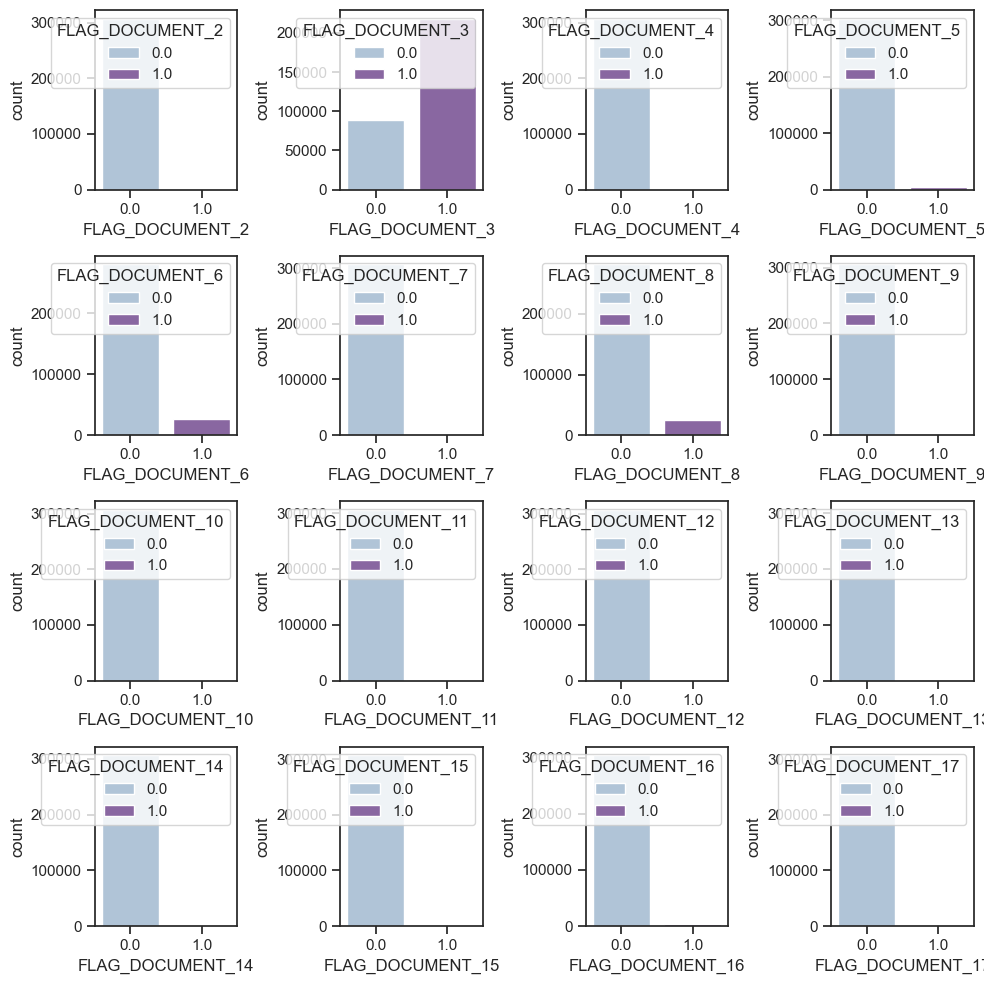

In [401]:
# Les variables flag_document : documents fournis par les clients
cols_flag_document = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 
          'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
          'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 
          'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

# f, axes = plt.subplots(1, 4)
fig , ax = plt.subplots(4,4, figsize = (10,10))     # set up 2 x 2 frame count plot with figsize 10 x 10


for i , subplots in zip (cols_flag_document, ax.flatten()):
    sns.countplot(
        x = i,
        data = df_app_train,
        hue = df_app_train[i],
        ax = subplots,
        palette = 'BuPu'
    )
plt.tight_layout()
plt.show()


In [402]:
# On garde uniquement les variables FLAG_DOCUMENT_3, FLAG_DOCUMENT_6 et FLAG_DOCUMENT_8
# Suppression des autres variables
cols_flag_to_drop = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',  
          'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
          'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 
          'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

df_app_train.drop(labels=cols_flag_to_drop, axis=1, inplace=True)

In [403]:
print(df_app_train.shape)
df_app_train.info()

(307511, 59)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 59 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  float64
 1   CNT_CHILDREN                  307511 non-null  object 
 2   AMT_INCOME_TOTAL              307511 non-null  float64
 3   AMT_CREDIT                    307511 non-null  float64
 4   AMT_ANNUITY                   307511 non-null  float64
 5   AMT_GOODS_PRICE               307511 non-null  float64
 6   REGION_POPULATION_RELATIVE    307511 non-null  float64
 7   DAYS_BIRTH                    307511 non-null  float64
 8   DAYS_EMPLOYED                 307511 non-null  float64
 9   DAYS_REGISTRATION             307511 non-null  float64
 10  DAYS_ID_PUBLISH               307511 non-null  float64
 11  FLAG_EMP_PHONE                307511 non-null  float64
 12  FLAG_WORK_PHONE               3

In [404]:
list_var = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'] # Variables presques toutes nulles
df_app_train.drop(labels=list_var, axis=1, inplace=True)

In [405]:
# Ajout de nouvelles features (percentages)
df_app_train['DAYS_EMPLOYED_PERC'] = df_app_train['DAYS_EMPLOYED'] / df_app_train['DAYS_BIRTH'] # taux de jours employés par rapport à l'âge
df_app_train['INCOME_CREDIT_PERC'] = df_app_train['AMT_INCOME_TOTAL'] / df_app_train['AMT_CREDIT'] # 
df_app_train['INCOME_PER_PERSON'] = df_app_train['AMT_INCOME_TOTAL'] / df_app_train['CNT_FAM_MEMBERS'] # revenu par membre du foyer
df_app_train['ANNUITY_INCOME_PERC'] = df_app_train['AMT_ANNUITY'] / df_app_train['AMT_INCOME_TOTAL'] # part de l'annuité par rapport au salaire total du client
df_app_train['PAYMENT_RATE'] = df_app_train['AMT_ANNUITY'] / df_app_train['AMT_CREDIT'] # taux de paiement(somme remboursée) par rapport à la somme finale du crédit par année (previous application)

## Corrélation Spearman

In [93]:
# - Traitement des missing values Imputation : Médiane/Min/Max pour valerus numériques + Valeurs catégorielles
# - Ajout de colonnes ou discretisation des valeurs continues (bins)
# - Check corrélation par paire et suppression si très corrélés
# Khi2
# RFE
# Passer sur tous les fichiers et en faire des fonctions par fichier

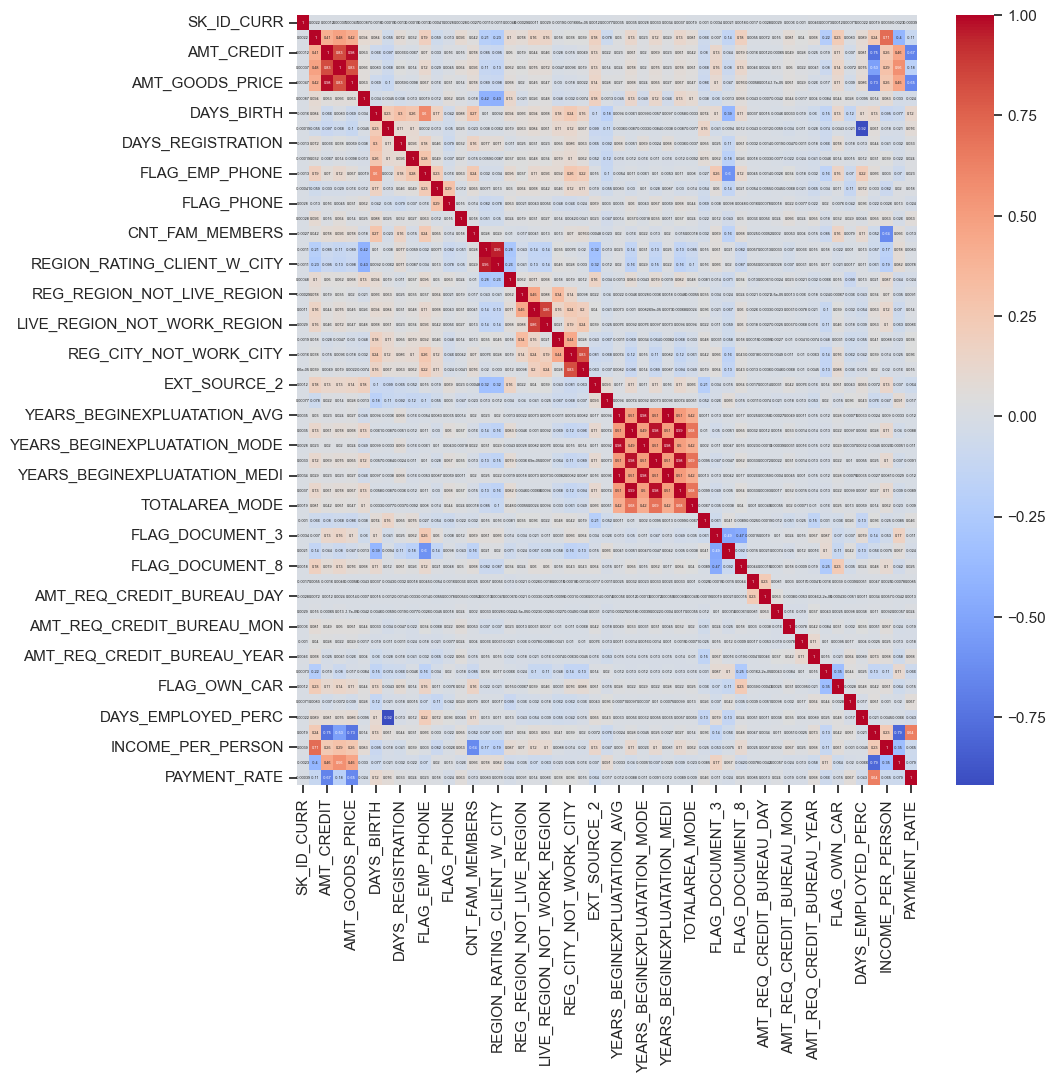

[('YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_AVG'),
 ('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI'),
 ('FLOORSMAX_AVG', 'FLOORSMAX_MEDI'),
 ('FLOORSMAX_MEDI', 'FLOORSMAX_AVG'),
 ('AMT_CREDIT', 'AMT_GOODS_PRICE'),
 ('AMT_GOODS_PRICE', 'AMT_CREDIT'),
 ('FLOORSMAX_MODE', 'FLOORSMAX_MEDI'),
 ('FLOORSMAX_MEDI', 'FLOORSMAX_MODE'),
 ('YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE'),
 ('YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI'),
 ('YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG'),
 ('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE'),
 ('FLOORSMAX_MODE', 'FLOORSMAX_AVG'),
 ('FLOORSMAX_AVG', 'FLOORSMAX_MODE'),
 ('REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT'),
 ('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'),
 ('DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC'),
 ('DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED'),
 ('LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION'),
 ('REG_REGION_NOT_WORK_REGION', 'LIV

In [406]:
# Corrélation Spearman
# Compute the correlation matrix
# corr_matrix = application_train.corr(numeric_only=True)
# corr_matrix = X_train_joined.corr(numeric_only=True, method = 'spearman')

# # Plot the heatmap of the correlation matrix
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 35 / np.sqrt(len(corr_matrix))})
# plt.show()

# # Identify highly correlated pairs
# threshold = 0.8
# corr_pairs = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
# high_corr = [(a, b) for a, b in corr_pairs.index if a != b and corr_pairs[(a, b)] > threshold]
# high_corr

check_spearman_correlation(df_app_train, seuil = 0.8)

In [407]:
# Drop colonnes, une parmi les paires de colonnes très corrélées
cols_to_drop = ['AMT_GOODS_PRICE', 'FLOORSMAX_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI']
df_app_train.drop(labels=cols_to_drop, axis=1, inplace=True)

In [ ]:
# Categorical features with One-Hot encode
# app, cat_cols = one_hot_encoder(df_app_train, nan_as_category= False) # à faire après feature engineering

In [411]:
# Réintroduction TARGET
df_app_train['TARGET'] = y_train
df_app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 56 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  float64
 1   CNT_CHILDREN                 307511 non-null  object 
 2   AMT_INCOME_TOTAL             307511 non-null  float64
 3   AMT_CREDIT                   307511 non-null  float64
 4   AMT_ANNUITY                  307511 non-null  float64
 5   REGION_POPULATION_RELATIVE   307511 non-null  float64
 6   DAYS_BIRTH                   307511 non-null  float64
 7   DAYS_EMPLOYED                307511 non-null  float64
 8   DAYS_REGISTRATION            307511 non-null  float64
 9   DAYS_ID_PUBLISH              307511 non-null  float64
 10  FLAG_EMP_PHONE               307511 non-null  float64
 11  FLAG_WORK_PHONE              307511 non-null  float64
 12  FLAG_PHONE                   307511 non-null  float64
 13 

# Previous Application

In [412]:
previous_application.isna().mean().sort_values(ascending=False) * 100


RATE_INTEREST_PRIVILEGED       99.643698
RATE_INTEREST_PRIMARY          99.643698
AMT_DOWN_PAYMENT               53.636480
RATE_DOWN_PAYMENT              53.636480
NAME_TYPE_SUITE                49.119754
DAYS_TERMINATION               40.298129
DAYS_FIRST_DRAWING             40.298129
DAYS_FIRST_DUE                 40.298129
DAYS_LAST_DUE_1ST_VERSION      40.298129
DAYS_LAST_DUE                  40.298129
NFLAG_INSURED_ON_APPROVAL      40.298129
AMT_GOODS_PRICE                23.081773
AMT_ANNUITY                    22.286665
CNT_PAYMENT                    22.286366
PRODUCT_COMBINATION             0.020716
AMT_CREDIT                      0.000060
SK_ID_PREV                      0.000000
AMT_APPLICATION                 0.000000
NAME_CONTRACT_TYPE              0.000000
SK_ID_CURR                      0.000000
WEEKDAY_APPR_PROCESS_START      0.000000
CODE_REJECT_REASON              0.000000
NAME_PAYMENT_TYPE               0.000000
DAYS_DECISION                   0.000000
NAME_CONTRACT_ST

In [419]:
def previous_applications(df, num_rows = None):
    df_prev = df.copy()
    # Process DAYS columns, Days 365.243 values -> nan
    col_days = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    for col in col_days:
        df_prev.loc[df_prev[col] == 365243, col] = np.nan

    # Delete cols with more than 40% missing values
    df_clean, cols_with_40pct_missing_values = drop_cols_with_missing_values(df_prev, seuil = 0.4)
    
    # Imputation missing values
    # Split numerical and categorical columns
    numeric_columns = df_clean.select_dtypes(include='number').columns
    categorical_columns = df_clean.select_dtypes(include='object').columns

    # Create two DataFrames, one for each data type
    data_numeric = df_clean[numeric_columns]
    data_categorical = df_clean[categorical_columns]

    # Impute missing values for numerical columns with median values
    si = SimpleImputer(missing_values=np.nan, strategy='median')
    data_numeric = pd.DataFrame(si.fit_transform(data_numeric), columns = si.get_feature_names_out())

    # Impute missing values for categorical columns with most frequent values
    si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    data_categorical = pd.DataFrame(si.fit_transform(data_categorical), columns = si.get_feature_names_out())

    # join the two masked dataframes back together
    df_clean = pd.concat([data_numeric, data_categorical], axis = 1)

    return df_clean

In [420]:
df_prev = previous_applications(previous_application)

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.
There are 11 columns that have more than 40.0% of missing values.



### Variables Numériques

In [ ]:
df_prev.isna().mean().sort_values(ascending=False) * 100
df_prev

# Les variables numériques
df_prev['DAYS_DECISION'] = round(df_prev['DAYS_DECISION'] / -365, 0)
df_prev.drop(labels=['SELLERPLACE_AREA', 'NFLAG_LAST_APPL_IN_DAY'], axis=1, inplace=True)
col_num = df_prev.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).select_dtypes(include=[np.number]).columns.to_list()
print(col_num)



['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'DAYS_DECISION', 'CNT_PAYMENT']


#### Corrélation Spearman

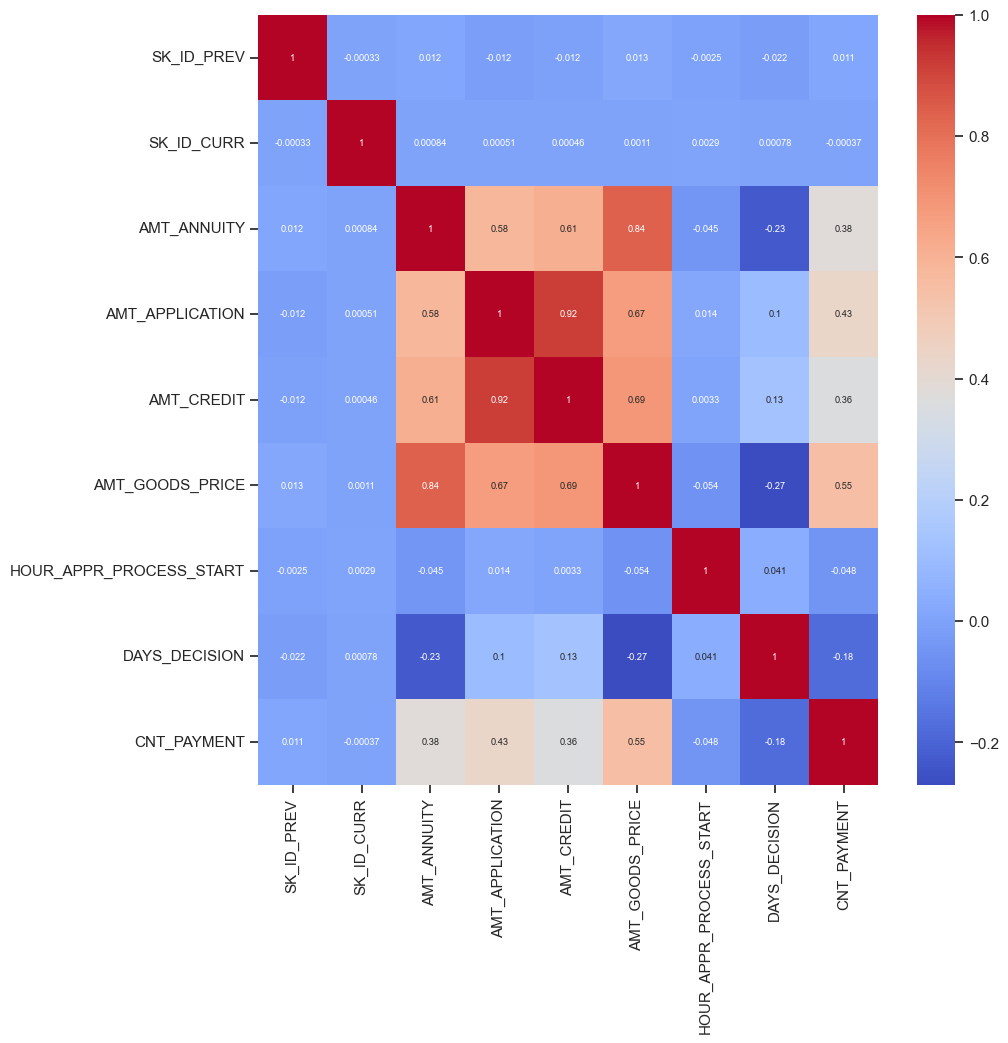

[('AMT_APPLICATION', 'AMT_CREDIT'),
 ('AMT_CREDIT', 'AMT_APPLICATION'),
 ('AMT_GOODS_PRICE', 'AMT_ANNUITY'),
 ('AMT_ANNUITY', 'AMT_GOODS_PRICE')]

In [ ]:
# Corrélation Spearman
# Compute the correlation matrix
check_spearman_correlation(df_prev, seuil=0.8)

In [424]:
# Drop colonnes, une parmi les paires de colonnes très corrélées
cols_to_drop = ['AMT_GOODS_PRICE']
df_prev.drop(labels=cols_to_drop, axis=1, inplace=True)

In [425]:
df_prev.info()
df_prev

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 23 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  float64
 1   SK_ID_CURR                   1670214 non-null  float64
 2   AMT_ANNUITY                  1670214 non-null  float64
 3   AMT_APPLICATION              1670214 non-null  float64
 4   AMT_CREDIT                   1670214 non-null  float64
 5   HOUR_APPR_PROCESS_START      1670214 non-null  float64
 6   DAYS_DECISION                1670214 non-null  float64
 7   CNT_PAYMENT                  1670214 non-null  float64
 8   NAME_CONTRACT_TYPE           1670214 non-null  object 
 9   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NAME_CASH_LOAN_PURPOSE       1670214 non-null  object 
 12  NAME_CONTRACT_STATUS         1670214 non-n

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,HOUR_APPR_PROCESS_START,DAYS_DECISION,CNT_PAYMENT,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,...,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,2030495.0,271877.0,1730.430,17145.0,17145.0,15.0,0.0,12.0,Consumer loans,SATURDAY,...,Cash through the bank,XAP,Repeater,Mobile,POS,XNA,Country-wide,Connectivity,middle,POS mobile with interest
1,2802425.0,108129.0,25188.615,607500.0,679671.0,11.0,0.0,36.0,Cash loans,THURSDAY,...,XNA,XAP,Repeater,XNA,Cash,x-sell,Contact center,XNA,low_action,Cash X-Sell: low
2,2523466.0,122040.0,15060.735,112500.0,136444.5,11.0,1.0,12.0,Cash loans,TUESDAY,...,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,XNA,high,Cash X-Sell: high
3,2819243.0,176158.0,47041.335,450000.0,470790.0,7.0,1.0,12.0,Cash loans,MONDAY,...,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,XNA,middle,Cash X-Sell: middle
4,1784265.0,202054.0,31924.395,337500.0,404055.0,9.0,2.0,24.0,Cash loans,THURSDAY,...,Cash through the bank,HC,Repeater,XNA,Cash,walk-in,Credit and cash offices,XNA,high,Cash Street: high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464.0,352015.0,14704.290,267295.5,311400.0,12.0,1.0,30.0,Consumer loans,WEDNESDAY,...,Cash through the bank,XAP,Refreshed,Furniture,POS,XNA,Stone,Furniture,low_normal,POS industry with interest
1670210,2357031.0,334635.0,6622.020,87750.0,64291.5,15.0,5.0,12.0,Consumer loans,TUESDAY,...,Cash through the bank,XAP,New,Furniture,POS,XNA,Stone,Furniture,middle,POS industry with interest
1670211,2659632.0,249544.0,11520.855,105237.0,102523.5,12.0,4.0,10.0,Consumer loans,MONDAY,...,Cash through the bank,XAP,Repeater,Consumer Electronics,POS,XNA,Country-wide,Consumer electronics,low_normal,POS household with interest
1670212,2785582.0,400317.0,18821.520,180000.0,191880.0,9.0,3.0,12.0,Cash loans,WEDNESDAY,...,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),XNA,low_normal,Cash X-Sell: low


### Variables Catégorielles

In [426]:
categorical_columns, styled_df = print_categorical_cols_info(df_prev)
styled_df


,categorical_columns,nb_distinct_values,list_of_values
0,NAME_CONTRACT_TYPE,4,"Cash loans, Consumer loans, Revolving loans, XNA"
1,WEEKDAY_APPR_PROCESS_START,7,"FRIDAY, MONDAY, SATURDAY, SUNDAY, THURSDAY, TUESDAY, WEDNESDAY"
2,FLAG_LAST_APPL_PER_CONTRACT,2,"N, Y"
3,NAME_CASH_LOAN_PURPOSE,25,"Building a house or an annex, Business development, Buying a garage, Buying a holiday home / land, Buying a home, Buying a new car, Buying a used car, Car repairs, Education, Everyday expenses, Furniture, Gasification / water supply, Hobby, Journey, Medicine, Money for a third person, Other, Payments on other loans, Purchase of electronic equipment, Refusal to name the goal, Repairs, Urgent needs, Wedding / gift / holiday, XAP, XNA"
4,NAME_CONTRACT_STATUS,4,"Approved, Canceled, Refused, Unused offer"
5,NAME_PAYMENT_TYPE,4,"Cash through the bank, Cashless from the account of the employer, Non-cash from your account, XNA"
6,CODE_REJECT_REASON,9,"CLIENT, HC, LIMIT, SCO, SCOFR, SYSTEM, VERIF, XAP, XNA"
7,NAME_CLIENT_TYPE,4,"New, Refreshed, Repeater, XNA"
8,NAME_GOODS_CATEGORY,28,"Additional Service, Animals, Audio/Video, Auto Accessories, Clothing and Accessories, Computers, Construction Materials, Consumer Electronics, Direct Sales, Education, Fitness, Furniture, Gardening, Homewares, House Construction, Insurance, Jewelry, Medical Supplies, Medicine, Mobile, Office Appliances, Other, Photo / Cinema Equipment, Sport and Leisure, Tourism, Vehicles, Weapon, XNA"
9,NAME_PORTFOLIO,5,"Cards, Cars, Cash, POS, XNA"


In [427]:
for i in categorical_columns:
    categorial_col_desc(df_prev, i)

NAME_CONTRACT_TYPE
                     COUNT      RATIO
NAME_CONTRACT_TYPE                   
Cash loans          747553  44.757917
Consumer loans      729151  43.656142
Revolving loans     193164  11.565225
XNA                    346   0.020716


WEEKDAY_APPR_PROCESS_START
                             COUNT      RATIO
WEEKDAY_APPR_PROCESS_START                   
TUESDAY                     255118  15.274570
WEDNESDAY                   255010  15.268103
MONDAY                      253557  15.181109
FRIDAY                      252048  15.090761
THURSDAY                    249099  14.914197
SATURDAY                    240631  14.407196
SUNDAY                      164751   9.864065


FLAG_LAST_APPL_PER_CONTRACT
                               COUNT     RATIO
FLAG_LAST_APPL_PER_CONTRACT                   
Y                            1661739  99.49258
N                               8475   0.50742


NAME_CASH_LOAN_PURPOSE
                                   COUNT      RATIO
NAME_CASH_LOAN_

Sélection des colonnes

In [428]:
# On conserve les colonnes NAME_CONTRACT_STATUS et NAME_CONTRACT_TYPE, les autres contiennent pas un grand nombre de valeurs 'XNA' ou peu distribution peu discriminante (apporte peu d'informations)
num_columns = df_prev.select_dtypes(include=[np.number]).columns.to_list()
cols_cat_keep = ['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE']
cols_keep = num_columns + cols_cat_keep
df_prev = df_prev[cols_keep]
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 10 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   SK_ID_PREV               1670214 non-null  float64
 1   SK_ID_CURR               1670214 non-null  float64
 2   AMT_ANNUITY              1670214 non-null  float64
 3   AMT_APPLICATION          1670214 non-null  float64
 4   AMT_CREDIT               1670214 non-null  float64
 5   HOUR_APPR_PROCESS_START  1670214 non-null  float64
 6   DAYS_DECISION            1670214 non-null  float64
 7   CNT_PAYMENT              1670214 non-null  float64
 8   NAME_CONTRACT_STATUS     1670214 non-null  object 
 9   NAME_CONTRACT_TYPE       1670214 non-null  object 
dtypes: float64(8), object(2)
memory usage: 127.4+ MB


#### Agrégations des variables

In [429]:
prev = df_prev.copy()
prev, cat_cols = one_hot_encoder(prev, nan_as_category= False)

In [430]:
cat_cols

['NAME_CONTRACT_STATUS_Approved',
 'NAME_CONTRACT_STATUS_Canceled',
 'NAME_CONTRACT_STATUS_Refused',
 'NAME_CONTRACT_STATUS_Unused_offer',
 'NAME_CONTRACT_TYPE_Cash_loans',
 'NAME_CONTRACT_TYPE_Consumer_loans',
 'NAME_CONTRACT_TYPE_Revolving_loans',
 'NAME_CONTRACT_TYPE_XNA']

In [431]:
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['mean'],
    'AMT_APPLICATION': ['mean'],
    'AMT_CREDIT': ['mean'],
    'APP_CREDIT_PERC': ['mean', 'var'],
    'HOUR_APPR_PROCESS_START': ['mean'],
    'DAYS_DECISION': ['mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

In [432]:
prev_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338857 entries, 100001.0 to 456255.0
Data columns (total 35 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   PREV_AMT_ANNUITY_MEAN                         338857 non-null  float64
 1   PREV_AMT_APPLICATION_MEAN                     338857 non-null  float64
 2   PREV_AMT_CREDIT_MEAN                          338857 non-null  float64
 3   PREV_APP_CREDIT_PERC_MEAN                     338605 non-null  float64
 4   PREV_APP_CREDIT_PERC_VAR                      267821 non-null  float64
 5   PREV_HOUR_APPR_PROCESS_START_MEAN             338857 non-null  float64
 6   PREV_DAYS_DECISION_MEAN                       338857 non-null  float64
 7   PREV_CNT_PAYMENT_MEAN                         338857 non-null  float64
 8   PREV_CNT_PAYMENT_SUM                          338857 non-null  float64
 9   PREV_NAME_CONTRACT_STATUS_Approved_MEAN     

In [433]:
# Après chaque join traiter les NAs
df_join_1 = df_app_train.merge(prev_agg, how='left', on='SK_ID_CURR')

In [434]:
df_join_1.shape

(307511, 91)

In [435]:
df_join_1.isna().mean() *100

cols_with_missing_values = [col for col in df_join_1.columns if df_join_1[col].isnull().mean() > 0]
for col in cols_with_missing_values:
    df_join_1[col] = df_join_1[col].fillna(0)

In [437]:
df_join_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 91 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   SK_ID_CURR                                    307511 non-null  float64
 1   CNT_CHILDREN                                  307511 non-null  object 
 2   AMT_INCOME_TOTAL                              307511 non-null  float64
 3   AMT_CREDIT                                    307511 non-null  float64
 4   AMT_ANNUITY                                   307511 non-null  float64
 5   REGION_POPULATION_RELATIVE                    307511 non-null  float64
 6   DAYS_BIRTH                                    307511 non-null  float64
 7   DAYS_EMPLOYED                                 307511 non-null  float64
 8   DAYS_REGISTRATION                             307511 non-null  float64
 9   DAYS_ID_PUBLISH                               30

# Bureau and Balance

Drop Colonnes Missing Values

In [438]:
df_bureau = bureau.copy()

# Delete cols with missing values
df_bureau, cols_with_missing_values = drop_cols_with_missing_values(df_bureau, seuil = 0.05)


Your selected dataframe has 17 columns.
There are 7 columns that have missing values.
There are 6 columns that have more than 5.0% of missing values.



In [439]:
categorical_columns, styled_df = print_categorical_cols_info(df_bureau)
styled_df

,categorical_columns,nb_distinct_values,list_of_values
0,CREDIT_ACTIVE,4,"Active, Bad debt, Closed, Sold"
1,CREDIT_CURRENCY,4,"currency 1, currency 2, currency 3, currency 4"
2,CREDIT_TYPE,15,"Another type of loan, Car loan, Cash loan (non-earmarked), Consumer credit, Credit card, Interbank credit, Loan for business development, Loan for purchase of shares (margin lending), Loan for the purchase of equipment, Loan for working capital replenishment, Microloan, Mobile operator loan, Mortgage, Real estate loan, Unknown type of loan"


In [440]:

for i in categorical_columns:
    categorial_col_desc(df_bureau, i)

CREDIT_ACTIVE
                 COUNT      RATIO
CREDIT_ACTIVE                    
Closed         1079273  62.879014
Active          630607  36.739496
Sold              6527   0.380266
Bad debt            21   0.001223


CREDIT_CURRENCY
                   COUNT      RATIO
CREDIT_CURRENCY                    
currency 1       1715020  99.917969
currency 2          1224   0.071311
currency 3           174   0.010137
currency 4            10   0.000583


CREDIT_TYPE
                                                COUNT      RATIO
CREDIT_TYPE                                                     
Consumer credit                               1251615  72.919750
Credit card                                    402195  23.432093
Car loan                                        27690   1.613234
Mortgage                                        18391   1.071469
Microloan                                       12413   0.723188
Loan for business development                    1975   0.115065
Another type o

### Variables catégorielles : Réduction dimensions

In [441]:
# CREDIT_CURRENCY apporte très peu d'information
df_bureau.drop(columns=['CREDIT_CURRENCY'], axis=1, inplace=True)

map_credit_active = {'Closed': 'Closed',
                     'Active': 'Active',
                     'Sold': 'Sold or Bad debt',
                     'Bad debt': 'Sold or Bad debt'}

df_bureau['CREDIT_ACTIVE'] = df_bureau['CREDIT_ACTIVE'].map(map_credit_active)
df_bureau['CREDIT_TYPE'] = np.where(df_bureau['CREDIT_TYPE'].isin(['Consumer credit', 'Credit card']), df_bureau['CREDIT_TYPE'], 'Other')


In [442]:
categorical_columns, styled_df = print_categorical_cols_info(df_bureau)
styled_df

,categorical_columns,nb_distinct_values,list_of_values
0,CREDIT_ACTIVE,3,"Active, Closed, Sold or Bad debt"
1,CREDIT_TYPE,3,"Consumer credit, Credit card, Other"


In [443]:
df_bureau, bureau_cat = one_hot_encoder(df_bureau, nan_as_category=False)

In [444]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   SK_ID_CURR                      int64  
 1   SK_ID_BUREAU                    int64  
 2   DAYS_CREDIT                     int64  
 3   CREDIT_DAY_OVERDUE              int64  
 4   CNT_CREDIT_PROLONG              int64  
 5   AMT_CREDIT_SUM                  float64
 6   AMT_CREDIT_SUM_OVERDUE          float64
 7   DAYS_CREDIT_UPDATE              int64  
 8   CREDIT_ACTIVE_Active            bool   
 9   CREDIT_ACTIVE_Closed            bool   
 10  CREDIT_ACTIVE_Sold_or_Bad_debt  bool   
 11  CREDIT_TYPE_Consumer_credit     bool   
 12  CREDIT_TYPE_Credit_card         bool   
 13  CREDIT_TYPE_Other               bool   
dtypes: bool(6), float64(2), int64(6)
memory usage: 114.6 MB


### Variables Numériques

In [445]:
# Les variables numériques
var_num = bureau.drop(labels=['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1).select_dtypes(include=[np.number]).columns.to_list()
print(var_num)
var_num = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE']

df_bureau[var_num].describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:].T

['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']


,mean,std,min,1%,10%,25%,50%,75%,80%,90%,95%,99%,max
DAYS_CREDIT,-1142.107685,7.951649e+02,-2922.0,-2867.0,-2443.0,-1666.0,-987.0,-474.0,-385.0,-215.000,-125.0,-38.0,0.0
CREDIT_DAY_OVERDUE,0.818167,3.654443e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,2792.0
CNT_CREDIT_PROLONG,0.006410,9.622391e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,9.0
AMT_CREDIT_SUM,354994.591918,1.149811e+06,0.0,0.0,22500.0,51300.0,125518.5,315000.0,423000.0,778754.736,1350000.0,3700916.1,585000000.0
AMT_CREDIT_SUM_OVERDUE,37.912758,5.937650e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,3756681.0
DAYS_CREDIT_UPDATE,-593.748320,7.207473e+02,-41947.0,-2531.0,-1561.0,-908.0,-395.0,-33.0,-25.0,-13.000,-8.0,-3.0,372.0


In [446]:
col_to_drop = ['CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_OVERDUE'] # 99% des valeurs sont à 0
df_bureau.drop(labels=col_to_drop, axis=1, inplace= True)

### Corrélation Spearman

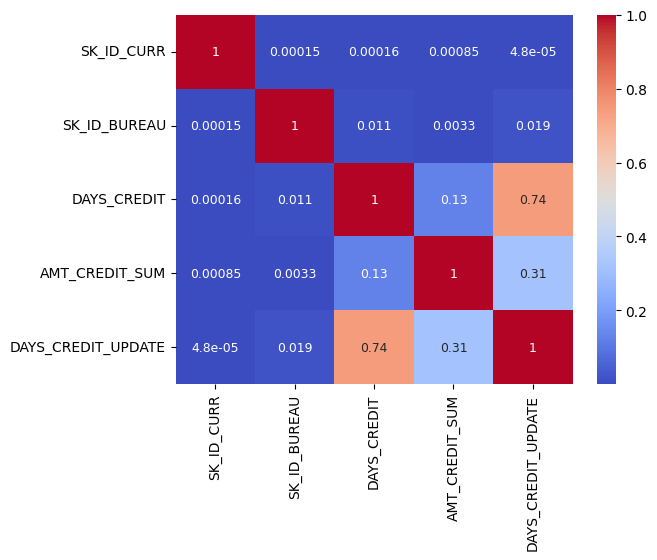

[('DAYS_CREDIT', 'DAYS_CREDIT_UPDATE'), ('DAYS_CREDIT_UPDATE', 'DAYS_CREDIT')]

In [217]:
check_spearman_correlation(df_bureau, seuil = 0.7)

In [447]:
df_bureau.drop(labels=['DAYS_CREDIT_UPDATE'], axis=1, inplace=True)
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   SK_ID_CURR                      int64  
 1   SK_ID_BUREAU                    int64  
 2   DAYS_CREDIT                     int64  
 3   AMT_CREDIT_SUM                  float64
 4   CREDIT_ACTIVE_Active            bool   
 5   CREDIT_ACTIVE_Closed            bool   
 6   CREDIT_ACTIVE_Sold_or_Bad_debt  bool   
 7   CREDIT_TYPE_Consumer_credit     bool   
 8   CREDIT_TYPE_Credit_card         bool   
 9   CREDIT_TYPE_Other               bool   
dtypes: bool(6), float64(1), int64(3)
memory usage: 62.2 MB


## Bureau Balance

In [448]:
bureau_balance.info()
df_bureau_balance = bureau_balance.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


### Variables Catégorielles : Réduction dimension

In [449]:

map_statut_bureau = {'C': 'CLOSED',
                     '0': 'NO_DPD',
                     '1': 'WITH_DPD',
                     '2': 'WITH_DPD',
                     '3': 'WITH_DPD',
                     '4': 'WITH_DPD',
                     '5': 'WITH_DPD',
                     'X': 'X'}

df_bureau_balance['STATUS'] = df_bureau_balance['STATUS'].map(map_statut_bureau)

In [450]:
bb, bb_cat = one_hot_encoder(df_bureau_balance, nan_as_category=False)

In [451]:
bb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 6 columns):
 #   Column           Dtype
---  ------           -----
 0   SK_ID_BUREAU     int64
 1   MONTHS_BALANCE   int64
 2   STATUS_CLOSED    bool 
 3   STATUS_NO_DPD    bool 
 4   STATUS_WITH_DPD  bool 
 5   STATUS_X         bool 
dtypes: bool(4), int64(2)
memory usage: 520.7 MB


### Agrégations

In [452]:
 # Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
df_bureau = df_bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
df_bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
# del bb, bb_agg
# gc.collect()

In [453]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 16 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   SK_ID_CURR                      int64  
 1   DAYS_CREDIT                     int64  
 2   AMT_CREDIT_SUM                  float64
 3   CREDIT_ACTIVE_Active            bool   
 4   CREDIT_ACTIVE_Closed            bool   
 5   CREDIT_ACTIVE_Sold_or_Bad_debt  bool   
 6   CREDIT_TYPE_Consumer_credit     bool   
 7   CREDIT_TYPE_Credit_card         bool   
 8   CREDIT_TYPE_Other               bool   
 9   MONTHS_BALANCE_MIN              float64
 10  MONTHS_BALANCE_MAX              float64
 11  MONTHS_BALANCE_SIZE             float64
 12  STATUS_CLOSED_MEAN              float64
 13  STATUS_NO_DPD_MEAN              float64
 14  STATUS_WITH_DPD_MEAN            float64
 15  STATUS_X_MEAN                   float64
dtypes: bool(6), float64(8), int64(2)
memory usage: 140.8 MB


In [454]:
df_bureau.isna().mean()*100


SK_ID_CURR                         0.000000
DAYS_CREDIT                        0.000000
AMT_CREDIT_SUM                     0.000757
CREDIT_ACTIVE_Active               0.000000
CREDIT_ACTIVE_Closed               0.000000
CREDIT_ACTIVE_Sold_or_Bad_debt     0.000000
CREDIT_TYPE_Consumer_credit        0.000000
CREDIT_TYPE_Credit_card            0.000000
CREDIT_TYPE_Other                  0.000000
MONTHS_BALANCE_MIN                54.885728
MONTHS_BALANCE_MAX                54.885728
MONTHS_BALANCE_SIZE               54.885728
STATUS_CLOSED_MEAN                54.885728
STATUS_NO_DPD_MEAN                54.885728
STATUS_WITH_DPD_MEAN              54.885728
STATUS_X_MEAN                     54.885728
dtype: float64

In [455]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['mean'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# Bureau: Active credits - using only numerical aggregations
active = df_bureau[df_bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
# del active, active_agg
# gc.collect()
# Bureau: Closed credits - using only numerical aggregations
closed = df_bureau[df_bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

In [456]:
bureau_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305811 entries, 100001 to 456255
Data columns (total 31 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   BURO_DAYS_CREDIT_MEAN                     305811 non-null  float64
 1   BURO_AMT_CREDIT_SUM_MEAN                  305809 non-null  float64
 2   BURO_AMT_CREDIT_SUM_SUM                   305811 non-null  float64
 3   BURO_MONTHS_BALANCE_MIN_MIN               134542 non-null  float64
 4   BURO_MONTHS_BALANCE_MAX_MAX               134542 non-null  float64
 5   BURO_MONTHS_BALANCE_SIZE_MEAN             134542 non-null  float64
 6   BURO_MONTHS_BALANCE_SIZE_SUM              305811 non-null  float64
 7   BURO_CREDIT_ACTIVE_Active_MEAN            305811 non-null  float64
 8   BURO_CREDIT_ACTIVE_Closed_MEAN            305811 non-null  float64
 9   BURO_CREDIT_ACTIVE_Sold_or_Bad_debt_MEAN  305811 non-null  float64
 10  BURO_CREDIT_TYPE_Con

In [457]:
bureau_agg.shape

(305811, 31)

### Fusion all dfs & bureau and balance

In [458]:
#Fusion avec clean_X_train_join3
df_join_2 = df_join_1.merge(bureau_agg, how='left', on='SK_ID_CURR')
df_join_2.shape

(307511, 122)

In [459]:
cols_with_missing_values = [col for col in df_join_2.columns if df_join_2[col].isnull().mean() > 0]
for col in cols_with_missing_values:
    df_join_2[col] = df_join_2[col].fillna(0)

In [460]:
df_join_2.isna().mean()*100


SK_ID_CURR                                      0.0
CNT_CHILDREN                                    0.0
AMT_INCOME_TOTAL                                0.0
AMT_CREDIT                                      0.0
AMT_ANNUITY                                     0.0
REGION_POPULATION_RELATIVE                      0.0
DAYS_BIRTH                                      0.0
DAYS_EMPLOYED                                   0.0
DAYS_REGISTRATION                               0.0
DAYS_ID_PUBLISH                                 0.0
FLAG_EMP_PHONE                                  0.0
FLAG_WORK_PHONE                                 0.0
FLAG_PHONE                                      0.0
FLAG_EMAIL                                      0.0
CNT_FAM_MEMBERS                                 0.0
REGION_RATING_CLIENT                            0.0
REGION_RATING_CLIENT_W_CITY                     0.0
HOUR_APPR_PROCESS_START                         0.0
REG_REGION_NOT_LIVE_REGION                      0.0
REG_REGION_N

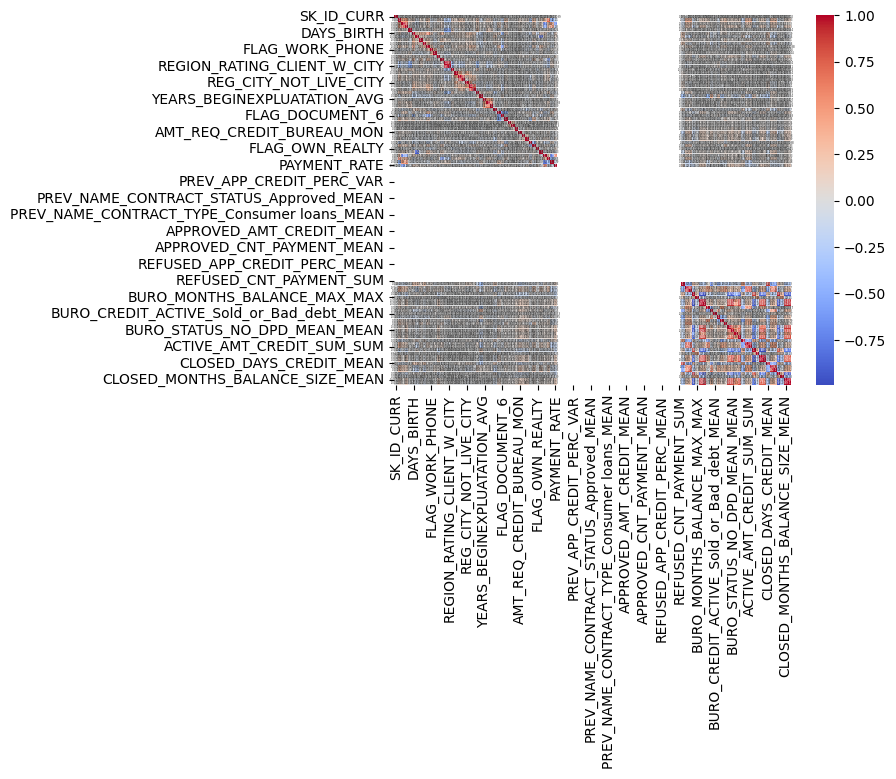

[('ACTIVE_MONTHS_BALANCE_SIZE_SUM', 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN'),
 ('ACTIVE_MONTHS_BALANCE_SIZE_MEAN', 'ACTIVE_MONTHS_BALANCE_SIZE_SUM'),
 ('ACTIVE_MONTHS_BALANCE_MIN_MIN', 'ACTIVE_MONTHS_BALANCE_SIZE_SUM'),
 ('ACTIVE_MONTHS_BALANCE_SIZE_SUM', 'ACTIVE_MONTHS_BALANCE_MIN_MIN'),
 ('ACTIVE_MONTHS_BALANCE_SIZE_MEAN', 'ACTIVE_MONTHS_BALANCE_MIN_MIN'),
 ('ACTIVE_MONTHS_BALANCE_MIN_MIN', 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN'),
 ('CLOSED_MONTHS_BALANCE_MIN_MIN', 'CLOSED_MONTHS_BALANCE_SIZE_SUM'),
 ('CLOSED_MONTHS_BALANCE_SIZE_SUM', 'CLOSED_MONTHS_BALANCE_MIN_MIN'),
 ('CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'CLOSED_MONTHS_BALANCE_SIZE_SUM'),
 ('CLOSED_MONTHS_BALANCE_SIZE_SUM', 'CLOSED_MONTHS_BALANCE_SIZE_MEAN'),
 ('BURO_MONTHS_BALANCE_MIN_MIN', 'BURO_MONTHS_BALANCE_SIZE_SUM'),
 ('BURO_MONTHS_BALANCE_SIZE_SUM', 'BURO_MONTHS_BALANCE_MIN_MIN'),
 ('BURO_MONTHS_BALANCE_SIZE_SUM', 'BURO_MONTHS_BALANCE_SIZE_MEAN'),
 ('BURO_MONTHS_BALANCE_SIZE_MEAN', 'BURO_MONTHS_BALANCE_SIZE_SUM'),
 ('CLOSED_MONTHS_BALAN

In [288]:
check_spearman_correlation(df_join_2, seuil = 0.7)

# Credit Card Balance

In [461]:
credit_card_balance.isna().mean()*100
df_credit_card = credit_card_balance.copy()


In [462]:
df_credit_card.dropna(axis=1, inplace=True)


In [463]:
df_credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 14 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   SK_ID_PREV                 int64  
 1   SK_ID_CURR                 int64  
 2   MONTHS_BALANCE             int64  
 3   AMT_BALANCE                float64
 4   AMT_CREDIT_LIMIT_ACTUAL    int64  
 5   AMT_DRAWINGS_CURRENT       float64
 6   AMT_PAYMENT_TOTAL_CURRENT  float64
 7   AMT_RECEIVABLE_PRINCIPAL   float64
 8   AMT_RECIVABLE              float64
 9   AMT_TOTAL_RECEIVABLE       float64
 10  CNT_DRAWINGS_CURRENT       int64  
 11  NAME_CONTRACT_STATUS       object 
 12  SK_DPD                     int64  
 13  SK_DPD_DEF                 int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 410.2+ MB


### Variables Catégorielles

In [464]:
categorial_col_desc(df_credit_card, 'NAME_CONTRACT_STATUS')

NAME_CONTRACT_STATUS
                        COUNT      RATIO
NAME_CONTRACT_STATUS                    
Active                3698436  96.305613
Completed              128918   3.356967
Signed                  11058   0.287945
Demand                   1365   0.035544
Sent proposal             513   0.013358
Refused                    17   0.000443
Approved                    5   0.000130




In [465]:
df_credit_card.drop(labels='NAME_CONTRACT_STATUS', axis=1, inplace=True)

### Variables Numériques

In [466]:
df_credit_card.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99]).T


,count,mean,std,min,1%,10%,25%,50%,75%,80%,90%,95%,99%,max
MONTHS_BALANCE,3840312.0,-34.521921,26.667751,-96.000,-93.00,-76.0,-55.0,-28.0,-11.00000,-9.000,-5.0000,-3.00000,-1.00000,-1.000
AMT_BALANCE,3840312.0,58300.155262,106307.031024,-420250.185,0.00,0.0,0.0,0.0,89046.68625,116880.705,180016.2000,257181.37875,466295.11605,1505902.185
AMT_CREDIT_LIMIT_ACTUAL,3840312.0,153807.957400,165145.699525,0.000,0.00,0.0,45000.0,112500.0,180000.00000,225000.000,427500.0000,450000.00000,765000.00000,1350000.000
AMT_DRAWINGS_CURRENT,3840312.0,7433.388179,33846.077333,-6211.620,0.00,0.0,0.0,0.0,0.00000,0.000,11250.0000,45000.00000,157500.00000,2287098.315
AMT_PAYMENT_TOTAL_CURRENT,3840312.0,7588.856739,32005.987768,0.000,0.00,0.0,0.0,0.0,6750.00000,9000.000,13500.0000,23400.00000,128614.92930,4278315.690
AMT_RECEIVABLE_PRINCIPAL,3840312.0,55965.876905,102533.616846,-423305.820,0.00,0.0,0.0,0.0,85359.24000,111982.275,173228.9265,247803.41475,448121.82510,1472316.795
AMT_RECIVABLE,3840312.0,58088.811177,105965.369908,-420250.185,-487.26,0.0,0.0,0.0,88899.49125,116663.391,179815.7700,256445.41500,464023.85670,1493338.185
AMT_TOTAL_RECEIVABLE,3840312.0,58098.285489,105971.801104,-420250.185,-486.63,0.0,0.0,0.0,88914.51000,116690.040,179830.1700,256468.50000,464025.50685,1493338.185
CNT_DRAWINGS_CURRENT,3840312.0,0.703144,3.190347,0.000,0.00,0.0,0.0,0.0,0.00000,0.000,1.0000,4.00000,14.00000,165.000
SK_DPD,3840312.0,9.283667,97.515700,0.000,0.00,0.0,0.0,0.0,0.00000,0.000,0.0000,0.00000,274.00000,3260.000


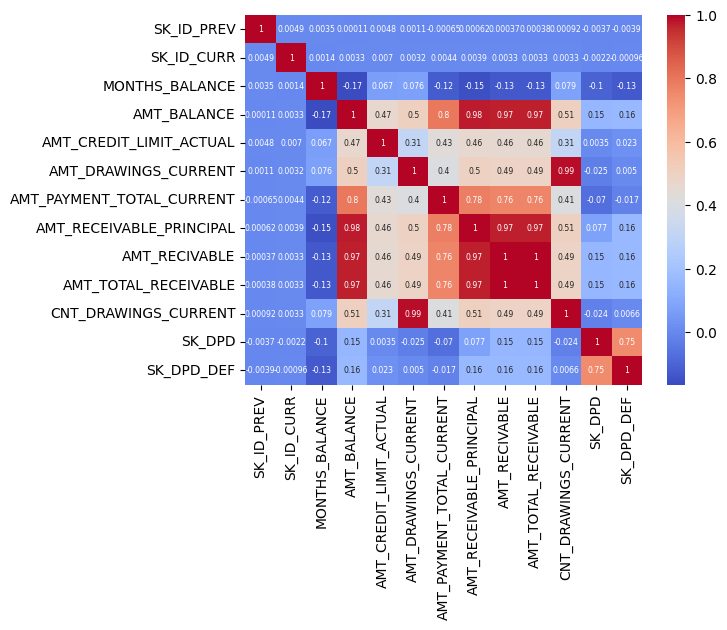

[('AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE'),
 ('AMT_TOTAL_RECEIVABLE', 'AMT_RECIVABLE'),
 ('AMT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_CURRENT'),
 ('CNT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_CURRENT'),
 ('AMT_BALANCE', 'AMT_RECEIVABLE_PRINCIPAL'),
 ('AMT_RECEIVABLE_PRINCIPAL', 'AMT_BALANCE'),
 ('AMT_TOTAL_RECEIVABLE', 'AMT_BALANCE'),
 ('AMT_BALANCE', 'AMT_TOTAL_RECEIVABLE'),
 ('AMT_BALANCE', 'AMT_RECIVABLE'),
 ('AMT_RECIVABLE', 'AMT_BALANCE'),
 ('AMT_RECIVABLE', 'AMT_RECEIVABLE_PRINCIPAL'),
 ('AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE'),
 ('AMT_RECEIVABLE_PRINCIPAL', 'AMT_TOTAL_RECEIVABLE'),
 ('AMT_TOTAL_RECEIVABLE', 'AMT_RECEIVABLE_PRINCIPAL'),
 ('AMT_PAYMENT_TOTAL_CURRENT', 'AMT_BALANCE'),
 ('AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT'),
 ('AMT_RECEIVABLE_PRINCIPAL', 'AMT_PAYMENT_TOTAL_CURRENT'),
 ('AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL'),
 ('AMT_TOTAL_RECEIVABLE', 'AMT_PAYMENT_TOTAL_CURRENT'),
 ('AMT_PAYMENT_TOTAL_CURRENT', 'AMT_TOTAL_RECEIVABLE'),
 ('AMT_PAYMENT_TOTAL_CURRENT', '

In [300]:
check_spearman_correlation(df_credit_card, seuil = 0.7)

In [467]:
# Suppression des variables très liées entre elles

cols_to_drop = ['AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 
                 'AMT_PAYMENT_TOTAL_CURRENT', 'CNT_DRAWINGS_CURRENT', 'SK_DPD', 'SK_DPD_DEF']

df_credit_card.drop(labels=cols_to_drop, axis=1, inplace=True)

df_credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 6 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   SK_ID_PREV               int64  
 1   SK_ID_CURR               int64  
 2   MONTHS_BALANCE           int64  
 3   AMT_BALANCE              float64
 4   AMT_CREDIT_LIMIT_ACTUAL  int64  
 5   AMT_DRAWINGS_CURRENT     float64
dtypes: float64(2), int64(4)
memory usage: 175.8 MB


In [468]:
cc, cat_cols = one_hot_encoder(df_credit_card, nan_as_category= False)
# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['mean', 'sum'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

In [469]:
cc_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103558 entries, 100006 to 456250
Data columns (total 9 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   CC_MONTHS_BALANCE_MEAN           103558 non-null  float64
 1   CC_MONTHS_BALANCE_SUM            103558 non-null  int64  
 2   CC_AMT_BALANCE_MEAN              103558 non-null  float64
 3   CC_AMT_BALANCE_SUM               103558 non-null  float64
 4   CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN  103558 non-null  float64
 5   CC_AMT_CREDIT_LIMIT_ACTUAL_SUM   103558 non-null  int64  
 6   CC_AMT_DRAWINGS_CURRENT_MEAN     103558 non-null  float64
 7   CC_AMT_DRAWINGS_CURRENT_SUM      103558 non-null  float64
 8   CC_COUNT                         103558 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 7.9 MB


### Fusion All and Credit Card

In [470]:
#Fusion avec clean_X_train_join3
df_join_3 = df_join_2.merge(cc_agg, how='left', on='SK_ID_CURR')
df_join_3.shape

(307511, 131)

In [471]:
cols_with_missing_values = [col for col in df_join_3.columns if df_join_3[col].isnull().mean() > 0]
for col in cols_with_missing_values:
    df_join_3[col] = df_join_3[col].fillna(0)

In [472]:
df_join_3.isna().mean()*100

SK_ID_CURR                                      0.0
CNT_CHILDREN                                    0.0
AMT_INCOME_TOTAL                                0.0
AMT_CREDIT                                      0.0
AMT_ANNUITY                                     0.0
REGION_POPULATION_RELATIVE                      0.0
DAYS_BIRTH                                      0.0
DAYS_EMPLOYED                                   0.0
DAYS_REGISTRATION                               0.0
DAYS_ID_PUBLISH                                 0.0
FLAG_EMP_PHONE                                  0.0
FLAG_WORK_PHONE                                 0.0
FLAG_PHONE                                      0.0
FLAG_EMAIL                                      0.0
CNT_FAM_MEMBERS                                 0.0
REGION_RATING_CLIENT                            0.0
REGION_RATING_CLIENT_W_CITY                     0.0
HOUR_APPR_PROCESS_START                         0.0
REG_REGION_NOT_LIVE_REGION                      0.0
REG_REGION_N

# Installments Payments


In [473]:
installments_payments.info()
installments_payments.isna().mean() * 100

df_ins = installments_payments.copy()
for col in ['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']:
    df_ins[col].fillna(0, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


C:\Users\fly\AppData\Local\Temp\ipykernel_29520\639778883.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ins[col].fillna(0, inplace=True)


In [474]:
df_ins.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).describe()


,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07
mean,8.566373e-01,1.887090e+01,-1.042270e+03,-1.050889e+03,1.705091e+04,1.723454e+04
std,1.035216e+00,2.666407e+01,8.009463e+02,8.006477e+02,5.057025e+04,5.473052e+04
min,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.394170e+03
50%,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.122185e+03
75%,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610591e+04
max,1.780000e+02,2.770000e+02,-1.000000e+00,0.000000e+00,3.771488e+06,3.771488e+06


In [475]:
df_ins['DAYS_INSTALMENT'] = round(df_ins['DAYS_INSTALMENT'] / -365, 0)
df_ins['DAYS_ENTRY_PAYMENT'] = round(df_ins['DAYS_ENTRY_PAYMENT'] / -365, 0)

In [476]:
ins, cat_cols = one_hot_encoder(df_ins, nan_as_category= False)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)


In [478]:
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
 8   PAYMENT_PERC            float64
 9   PAYMENT_DIFF            float64
 10  DPD                     float64
 11  DBD                     float64
dtypes: float64(9), int64(3)
memory usage: 1.2 GB


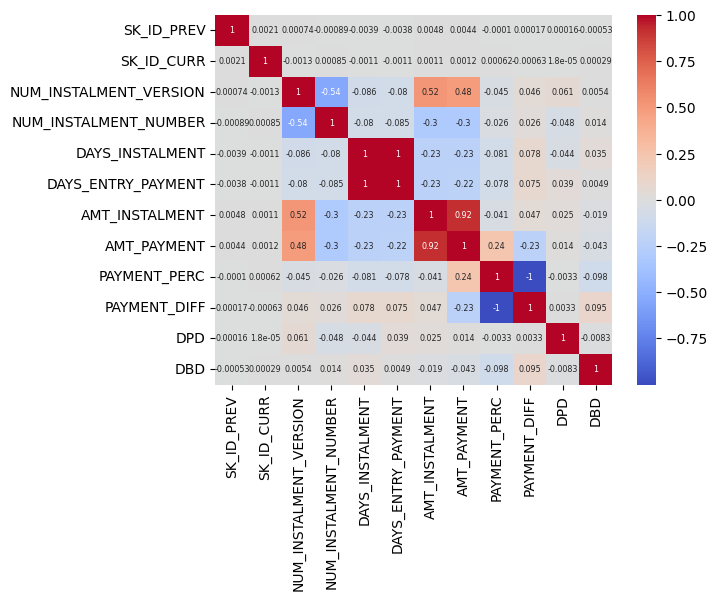

[('PAYMENT_PERC', 'PAYMENT_DIFF'),
 ('PAYMENT_DIFF', 'PAYMENT_PERC'),
 ('DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT'),
 ('DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT'),
 ('AMT_PAYMENT', 'AMT_INSTALMENT'),
 ('AMT_INSTALMENT', 'AMT_PAYMENT')]

In [318]:
check_spearman_correlation(ins, seuil= 0.7)

In [479]:
ins.drop(columns=['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT'], axis=1, inplace=True)
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   AMT_PAYMENT             float64
 5   PAYMENT_PERC            float64
 6   PAYMENT_DIFF            float64
 7   DPD                     float64
 8   DBD                     float64
dtypes: float64(6), int64(3)
memory usage: 934.2 MB


In [480]:
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean'],
    'DBD': ['max', 'mean'],
    'PAYMENT_PERC': ['max', 'mean'],
    'PAYMENT_DIFF': ['mean'],
    'AMT_PAYMENT': ['mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

In [481]:
ins_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339587 entries, 100001 to 456255
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  339587 non-null  int64  
 1   INSTAL_DPD_MAX                         339587 non-null  float64
 2   INSTAL_DPD_MEAN                        339587 non-null  float64
 3   INSTAL_DBD_MAX                         339587 non-null  float64
 4   INSTAL_DBD_MEAN                        339587 non-null  float64
 5   INSTAL_PAYMENT_PERC_MAX                339587 non-null  float64
 6   INSTAL_PAYMENT_PERC_MEAN               339587 non-null  float64
 7   INSTAL_PAYMENT_DIFF_MEAN               339587 non-null  float64
 8   INSTAL_AMT_PAYMENT_MEAN                339587 non-null  float64
 9   INSTAL_AMT_PAYMENT_SUM                 339587 non-null  float64
 10  INSTAL_COUNT                           339587 non-null  

### Fusion All & Installments Payments

In [482]:
#Fusion avec clean_X_train_join3
df_join_4 = df_join_3.merge(ins_agg, how='left', on='SK_ID_CURR')
df_join_4.shape

(307511, 142)

In [483]:
df_join_4.isna().mean()*100


SK_ID_CURR                                      0.000000
CNT_CHILDREN                                    0.000000
AMT_INCOME_TOTAL                                0.000000
AMT_CREDIT                                      0.000000
AMT_ANNUITY                                     0.000000
REGION_POPULATION_RELATIVE                      0.000000
DAYS_BIRTH                                      0.000000
DAYS_EMPLOYED                                   0.000000
DAYS_REGISTRATION                               0.000000
DAYS_ID_PUBLISH                                 0.000000
FLAG_EMP_PHONE                                  0.000000
FLAG_WORK_PHONE                                 0.000000
FLAG_PHONE                                      0.000000
FLAG_EMAIL                                      0.000000
CNT_FAM_MEMBERS                                 0.000000
REGION_RATING_CLIENT                            0.000000
REGION_RATING_CLIENT_W_CITY                     0.000000
HOUR_APPR_PROCESS_START        

In [484]:
cols_with_missing_values = [col for col in df_join_4.columns if df_join_4[col].isnull().mean() > 0]
for col in cols_with_missing_values:
    df_join_4[col] = df_join_4[col].fillna(0)

# POS CASH Balance

In [485]:
pos_cash.info()
pos_cash.isna().mean()*100
df_pos_cash = pos_cash.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [486]:
categorial_col_desc(df_pos_cash, 'NAME_CONTRACT_STATUS')

NAME_CONTRACT_STATUS
                         COUNT      RATIO
NAME_CONTRACT_STATUS                     
Active                 9151119  91.498764
Completed               744883   7.447819
Signed                   87260   0.872482
Demand                    7065   0.070640
Returned to the store     5461   0.054603
Approved                  4917   0.049163
Amortized debt             636   0.006359
Canceled                    15   0.000150
XNA                          2   0.000020




In [487]:
df_pos_cash.drop(labels='NAME_CONTRACT_STATUS', axis=1, inplace=True)


Variables Numériques

In [488]:
df_pos_cash.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])


,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,-9.400000e+01,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,-7.700000e+01,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
80%,-1.100000e+01,2.400000e+01,1.700000e+01,0.000000e+00,0.000000e+00


In [489]:
df_pos_cash.drop(labels=['SK_DPD', 'SK_DPD_DEF'], axis=1, inplace=True)


In [490]:
df_pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 5 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
dtypes: float64(2), int64(3)
memory usage: 381.5 MB


In [491]:
pos, cat_cols = one_hot_encoder(df_pos_cash, nan_as_category= False)
# Features
aggregations = {
    'MONTHS_BALANCE': ['mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

In [492]:
pos_agg

,POS_MONTHS_BALANCE_MEAN,POS_COUNT
SK_ID_CURR,,
100001,-72.555556,9
100002,-10.000000,19
100003,-43.785714,28
100004,-25.500000,4
100005,-20.000000,11
...,...,...
456251,-5.000000,9
456252,-79.000000,7
456253,-79.235294,17


### Fusion All & POS CASH Balance

In [493]:
#Fusion avec clean_X_train_join3
df_join_5 = df_join_4.merge(pos_agg, how='left', on='SK_ID_CURR')
df_join_5.shape

(307511, 144)

In [494]:
df_join_5.isna().mean()*100


SK_ID_CURR                                      0.000000
CNT_CHILDREN                                    0.000000
AMT_INCOME_TOTAL                                0.000000
AMT_CREDIT                                      0.000000
AMT_ANNUITY                                     0.000000
REGION_POPULATION_RELATIVE                      0.000000
DAYS_BIRTH                                      0.000000
DAYS_EMPLOYED                                   0.000000
DAYS_REGISTRATION                               0.000000
DAYS_ID_PUBLISH                                 0.000000
FLAG_EMP_PHONE                                  0.000000
FLAG_WORK_PHONE                                 0.000000
FLAG_PHONE                                      0.000000
FLAG_EMAIL                                      0.000000
CNT_FAM_MEMBERS                                 0.000000
REGION_RATING_CLIENT                            0.000000
REGION_RATING_CLIENT_W_CITY                     0.000000
HOUR_APPR_PROCESS_START        

In [495]:
cols_with_missing_values = [col for col in df_join_5.columns if df_join_5[col].isnull().mean() > 0]
for col in cols_with_missing_values:
    df_join_5[col] = df_join_5[col].fillna(0)

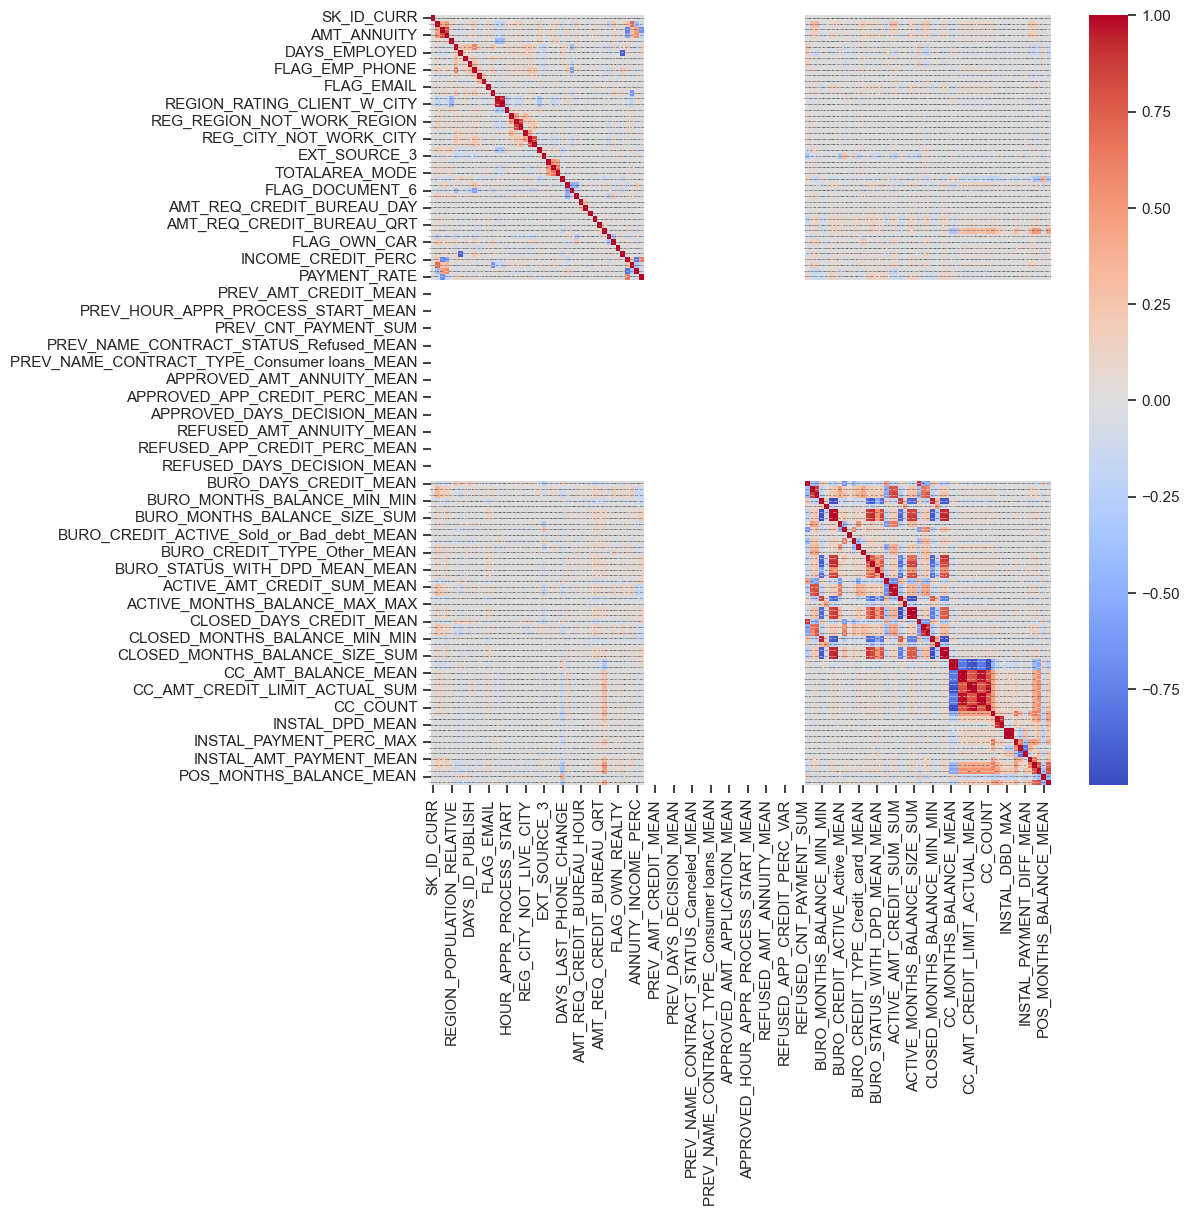

[('CC_COUNT', 'CC_MONTHS_BALANCE_SUM'),
 ('CC_MONTHS_BALANCE_SUM', 'CC_COUNT'),
 ('CC_MONTHS_BALANCE_MEAN', 'CC_MONTHS_BALANCE_SUM'),
 ('CC_MONTHS_BALANCE_SUM', 'CC_MONTHS_BALANCE_MEAN'),
 ('CC_MONTHS_BALANCE_MEAN', 'CC_COUNT'),
 ('CC_COUNT', 'CC_MONTHS_BALANCE_MEAN'),
 ('INSTAL_DBD_MEAN', 'INSTAL_DBD_MAX'),
 ('INSTAL_DBD_MAX', 'INSTAL_DBD_MEAN'),
 ('CC_AMT_BALANCE_MEAN', 'CC_AMT_BALANCE_SUM'),
 ('CC_AMT_BALANCE_SUM', 'CC_AMT_BALANCE_MEAN'),
 ('CC_AMT_DRAWINGS_CURRENT_SUM', 'CC_AMT_DRAWINGS_CURRENT_MEAN'),
 ('CC_AMT_DRAWINGS_CURRENT_MEAN', 'CC_AMT_DRAWINGS_CURRENT_SUM'),
 ('ACTIVE_MONTHS_BALANCE_SIZE_MEAN', 'ACTIVE_MONTHS_BALANCE_SIZE_SUM'),
 ('ACTIVE_MONTHS_BALANCE_SIZE_SUM', 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN'),
 ('ACTIVE_MONTHS_BALANCE_MIN_MIN', 'ACTIVE_MONTHS_BALANCE_SIZE_SUM'),
 ('ACTIVE_MONTHS_BALANCE_SIZE_SUM', 'ACTIVE_MONTHS_BALANCE_MIN_MIN'),
 ('ACTIVE_MONTHS_BALANCE_MIN_MIN', 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN'),
 ('ACTIVE_MONTHS_BALANCE_SIZE_MEAN', 'ACTIVE_MONTHS_BALANCE_MIN_MIN

In [352]:
sns.set(style="ticks", rc={'figure.figsize': (10, 10)})
check_spearman_correlation(df_join_5, seuil = 0.8)

In [496]:
df_join_5.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 144 columns):
 #    Column                                        Non-Null Count   Dtype  
---   ------                                        --------------   -----  
 0    SK_ID_CURR                                    307511 non-null  float64
 1    CNT_CHILDREN                                  307511 non-null  object 
 2    AMT_INCOME_TOTAL                              307511 non-null  float64
 3    AMT_CREDIT                                    307511 non-null  float64
 4    AMT_ANNUITY                                   307511 non-null  float64
 5    REGION_POPULATION_RELATIVE                    307511 non-null  float64
 6    DAYS_BIRTH                                    307511 non-null  float64
 7    DAYS_EMPLOYED                                 307511 non-null  float64
 8    DAYS_REGISTRATION                             307511 non-null  float64
 9    DAYS_ID_PUBLISH                    

# Export df preprocessed

In [498]:
df_join_5.to_csv('input/df_preprocessed.csv', encoding='utf-8', index=None)
